# Data cleaning for Twitter meta and text data 

**Code description**

This is a short jupyter notebook/lab script for data cleaning tasks for Twitter data.

Note that this script will require re-downloaded csv file accessed from Twitter's API. Input file needs to have tweet text for text analysis and created date of tweets for visualisation of tweets across time.

**Inporting file**: test.csv

**Exporting file**: topwords_20.csv

* Author: "Pu Yan (text cleaning and data analysis) and Huiyi Lv (test data and td-idf)"
* Version: "1.0"
* Maintainer: "Pu Yan"
* Email: "thuyanpu[AT]gmail.com"

In [3]:
# Importing libraries
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import lxml

# Importing Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# We will use spacy for lemmatization
## [installation] conda install -c conda-forge spacy
import spacy

# Importing NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['your_stop_words']) # Append the list of stop_words when neccessary

# Importing NLTK libraries for TD-IDF
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Importing text file
text_df = pd.read_csv('test.csv') # In this demo, we use 
print("There are {} data entries in the original dataset".format(len(text_df)))

# Removing duplicated text before running the analysis 
# column 'text' contains the raw text data
uni_text_df=text_df.drop_duplicates(['text'])[['author_id','created_at','text']]
print("There are {} unique data entries in the new dataset".format(len(uni_text_df)))

#replace URL in the text column
uni_text_df['text']= uni_text_df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

# Convert the text column into a list
## text is the column where your raw text is saved
data = uni_text_df.text.values.tolist()

In [22]:
# A glimpse of the data structure
uni_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50394 entries, 0 to 51449
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   author_id   50394 non-null  int64              
 1   created_at  50394 non-null  datetime64[ns, UTC]
 2   text        50394 non-null  object             
 3   date        50394 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 1.9+ MB


## Visualisation of date time information in the metadata

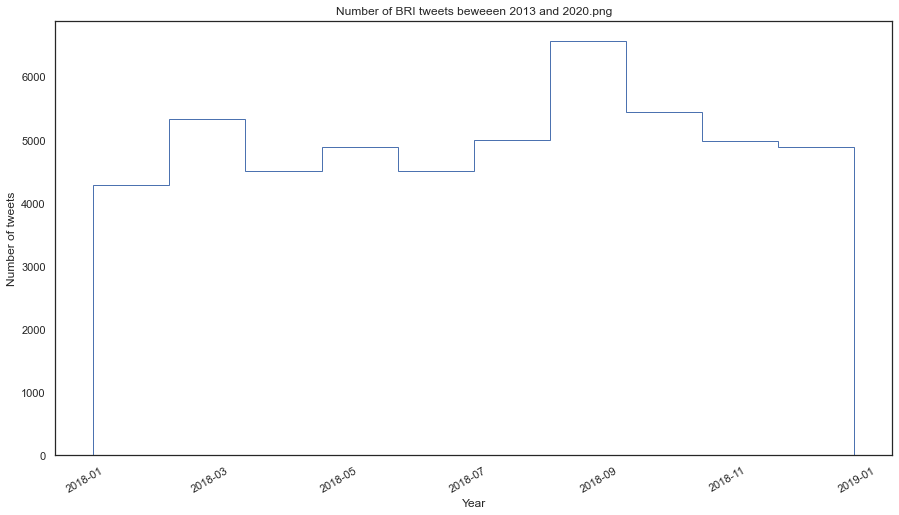

In [14]:
# Visualising tweet distribution over time
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# In our dataset, we have a column created_at, which saves the timestemp of tweets
# We will plot two figures using the column
uni_text_df['created_at'] = uni_text_df['created_at'].apply(pd.to_datetime)
uni_text_df['date'] = uni_text_df['created_at'].dt.date
sns.set(style='white')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
plt.hist(x="date", data=uni_text_df,histtype='step')
ax.set(xlabel="Year",
       ylabel="Number of tweets",
       title="Number of BRI tweets beweeen 2018 Jan and 2018 Jan.png")
plt.xticks(rotation=30)
plt.show()

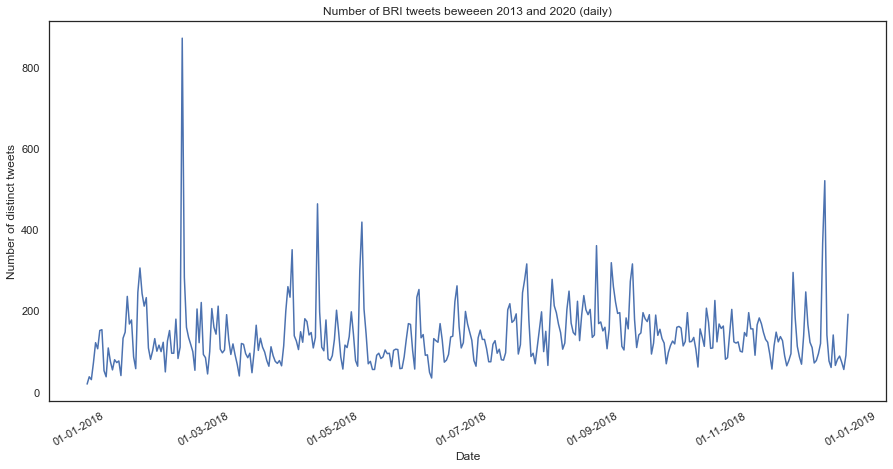

In [20]:
#plot data (daily)
fig, ax = plt.subplots(figsize=(15,7))
uni_text_df.groupby(['date'])['text'].count().plot(ax=ax)
ax.set(xlabel="Date",
       ylabel="Number of distinct tweets",
       title="Number of BRI tweets beweeen 2013 and 2020 (daily)")
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.show()

## Cleaning text data for content analysis

In [24]:
# Define functions for tokenisation, finding bigrams and trigrams, removing common stopwords, and lemmatization

# Tokenizing words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
print("Finished removing stop words!")

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
print("Finished Building Bigrams!")

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("Finished lemmatissation!")

Finished removing stop words!
Finished Building Bigrams!
Finished lemmatissation!


## Finding keywords (top 20) using TD-IDF

In [31]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

def getTFIDF(text_series):
    """Performs TF-IDF calculation on a matrix of words grouped into cells."""
    vectorizer = TfidfVectorizer()
    matrix = vectorizer.fit_transform(text_series).todense()
    matrix_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())
    return matrix_df.sum(axis=0).sort_values(ascending=False)

# Create Corpus for TD-IDF analysis 
uni_text_df["text_clean"] = data_lemmatized # Use the data_lemmatized for text analysis
uni_text_df["text_clean"] = [" ".join(text) for text in uni_text_df["text_clean"].values]

# Getting TD-IDF scores for words 
topwords = getTFIDF(uni_text_df["text_clean"])
topwords_20 = topwords[:20]

# Printing and saving top ranked 20 keywords
topwords_20.to_csv("topwords_20.csv")
print("The top ranked keywords by TD-IDF scores are:\n")
print(topwords_20)

The top ranked keywords by TD-IDF scores are:

road              3215.213525
belt              3153.141879
china             3101.505483
initiative        2283.165183
project           1033.626167
plan               927.730892
country            870.536105
pakistan           805.291226
chinese            801.558232
bri                777.108665
india              688.613236
beltandroad        674.479310
new                667.971287
debt               663.033417
infrastructure     562.032056
say                526.560540
investment         523.923929
asia               495.583941
trade              494.369411
global             484.411793
dtype: float64
